# Data Analysis of Vessel Data Partitions

This notebook performs data analysis of the synthetic data partitions.

## Outline

1. Import packages
2. Data loading
3. Analysis of individual datasets

# 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from src.utils.auxiliary_functions import load_data_and_set_index
from src.utils.plot_utils import violin_plot, get_density_plots_matrix

In [2]:
# Optional: Customize the plots configuration
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=30)

# 2. Data loading

All data are provided as csv files.

Provided datasets:
* `train.csv`
* `dev_in.csv`
* `dev_out.csv`

`Dev in` consists of data in-domain with `train` in terms of operational conditions while `dev_out` is a shifted dataset with respect to time and wind speed.

This tutorial assumes that all data files are placed in a local directory named `datasets`.

In [3]:
data_dir = "datasets"

# Load data partitions and concatenate all in to one dataframe named data
data = pd.DataFrame()
for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=data_dir + f"{partition}.csv", index_column_name="time_id")
    df["type"] = partition
    data = pd.concat([data, df])

data = data.sort_index()

In [4]:
data.head()

,draft_aft_telegram,draft_fore_telegram,stw,diff_speed_overground,awind_vcomp_provider,awind_ucomp_provider,rcurrent_vcomp,rcurrent_ucomp,comb_wind_swell_wave_height,timeSinceDryDock,power,type
time_id,,,,,,,,,,,,
0,7.705273,7.258722,10.921770,1.276760,4.103323,0.984349,0.272074,0.032076,1.838083,10776.0,5493.596307,train
1,7.810878,7.054659,12.702590,1.036016,5.548798,0.242906,0.418185,0.067841,1.838097,10777.0,6267.776914,train
4,7.490045,7.379479,13.846796,1.817522,6.693028,0.067190,0.383827,0.180903,1.961796,10780.0,9467.598354,train
6,7.492334,6.931855,14.133142,0.820007,7.882917,0.912182,0.437626,0.093848,1.731869,10782.0,7822.324704,train
9,7.412125,6.992691,14.056360,-0.339850,8.257932,1.713555,0.462206,0.092345,1.983767,10785.0,7086.420251,train


### Description of available features


* Description of available training features

| Feature name                | Units      | Description                                                                                | Source           |
|:----------------------------|:-----------|:-------------------------------------------------------------------------------------------|:-----------------|
| draft_aft_telegram          | m          | Draft at stern as reported by crew in daily reports                                        | Telegrams        |
| draft_fore_telegram         | m          | Draft at bow as reported by crew in daily reports                                          | Telegrams        |
| stw                         | knots      | Speed through water (i.e. relative to any currents) of the vessel as measured by speed log | Onboard sensor   |
| diff_speed_overground       | knots/3min | Acceleration of the vessel relative to ground                                              | GPS              |
| awind_vcomp_provider        | knots      | Apparent wind speed component relative to the vessel along its direction of motion         | Weather provider |
| awind_ucomp_provider        | knots      | Apparent wind speed component relative to vessel perpendicular to its direction            | Weather provider |
| rcurrent_vcomp              | knots      | Component of currents relative to the vessel along its direction of motion                 | Weather provider |
| rcurrent_ucomp              | knots      | Component of currents relative to vessel perpendicular to its direction                    | Weather provider |
| comb_wind_swell_wave_height | m          | Combined wave height due to wind and sea swell                                             | Weather provider |
| timeSinceDryDock            | minutes    | Time since the last dry dock cleaning of the vessel                                        | Calculated       |
| time_id                     | -          | Run number representing time. It is to be used as index of the records.                    | Calculated       |

* Description of target features

| Feature name | Units                                                                          | Description                                                                                                                               |
|:-------------|:-------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------|
| power        | kW                                                                             | Propeller shaft power. For synthetic data it is generated by the synthetic model and for real data is measured by an onboard torquemeter. |



# 3. Analysis of individual datasets

In [5]:
mask_per_dataset_type = {"train": data["type"] == "train",
                         "dev_in": data["type"] == "dev_in",
                         "dev_out": data["type"] == "dev_out",
                         "dev": ((data["type"] == "dev_in") | (data["type"] == "dev_out"))
                         }

### Size per dataset type

In [6]:
print("\n" + "Number of records per dataset:")
print("-------------------------------")
for k in mask_per_dataset_type.keys():
    print(f"{k}: ", data[mask_per_dataset_type[k]].shape[0])


Number of records per dataset:
-------------------------------
train:  523190
dev_in:  18108
dev_out:  18108
dev:  36216


### Violin plots

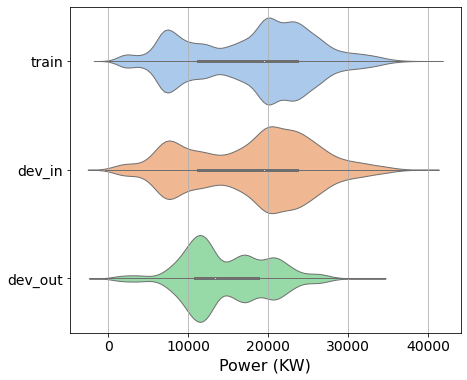

In [7]:
violin_plot(x=data["power"], y=data["type"], xlabel="Power (KW)")

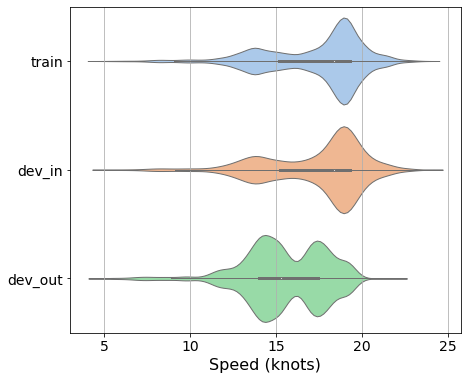

In [8]:
violin_plot(x=data["stw"], y=data["type"], xlabel="Speed (knots)")

### Power-Speed scatter plots 

In [9]:
feature_under_study = "awind_vcomp_provider"

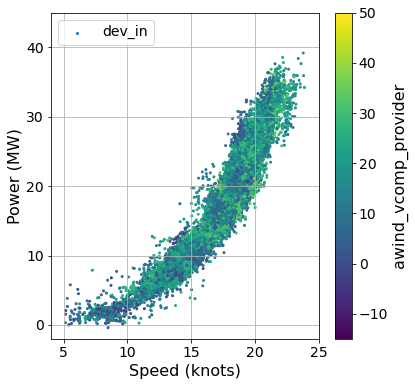

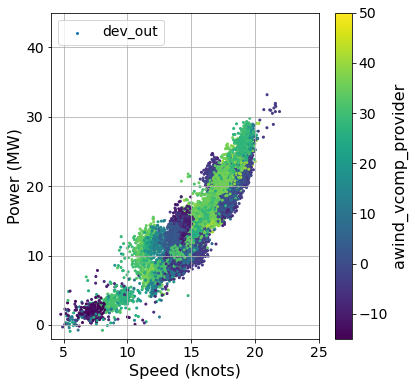

In [10]:
for k in ["dev_in", "dev_out"]:
    mask = data["type"] == k

    plt.figure(figsize=(6, 6))
    plt.scatter(data[mask]["stw"], data[mask]["power"] / 1e3,
                c=data[mask][feature_under_study],
                s=4, label=k)
    plt.legend(loc="upper left")
    plt.xlabel("Speed (knots)")
    plt.ylabel("Power (MW)")
    plt.xlim(4, 25)
    plt.ylim(-2, 45)
    plt.grid()

    cbar = plt.colorbar()
    cbar.set_label(feature_under_study, rotation=90)
    plt.clim(-15, 50)

    plt.show()
    plt.close()

### Density plots

In [11]:
colors_mapping = {"train": "C0", "dev_in": "C1", "dev_out": "C2"}

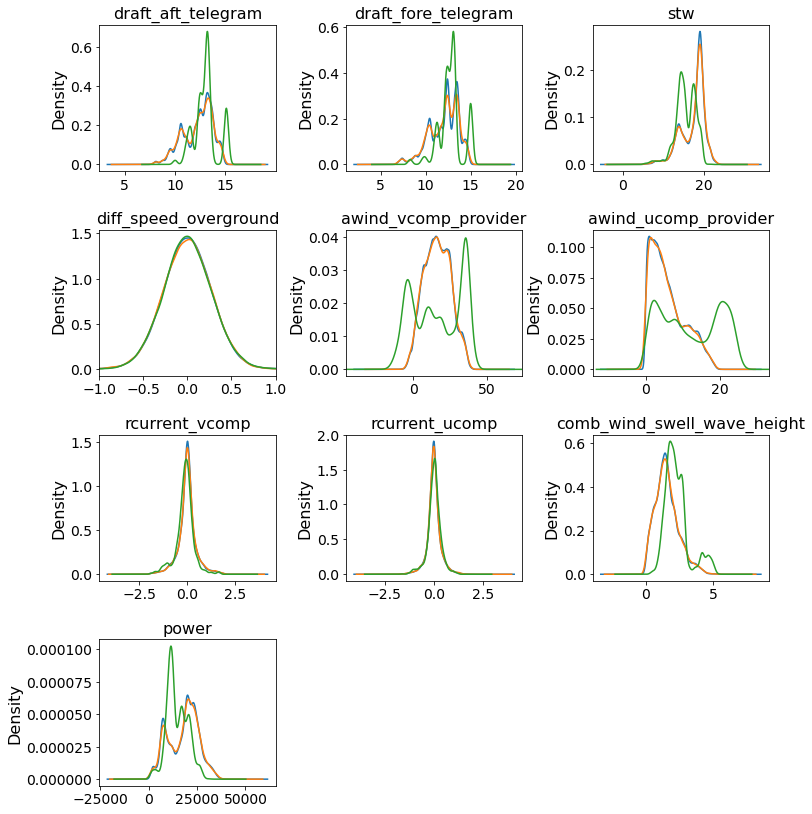

In [12]:
get_density_plots_matrix(data=data,
                         types_under_study=["train", "dev_in", "dev_out"],
                         features_under_study=[x for x in data.columns if x not in ["timeSinceDryDock", "type"]],
                         colors_mapping=colors_mapping)